In [240]:
# Import libraries necessary for this project
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import math
import random

In [215]:
#import dataset
fundamentals_dataset =  pd.read_csv('./datasets/fundamentals.csv', header=0)
prices_dataset =  pd.read_csv('./datasets/prices-split-adjusted.csv', header=0)
securities_dataset =  pd.read_csv('./datasets/securities.csv', header=0)

## Data Exploration

First, I'll make a cursory investigation about S&P 500 datasets. It'll help me better understand about data and problem.  
I'll use visualization and calculate statistics about dataset.

In [216]:
## check if nan exists
prices_dataset.isnull().values.any()

False

In [217]:
# helper function to plot prices.
def plot_close_prices_by_symbol(symbol, data):
    data_by_symbol = data[data['symbol']==symbol]
    close_prices = data_by_symbol.close.values.astype('float32')
    sns.tsplot(data=close_prices,value=symbol + " stock prices")

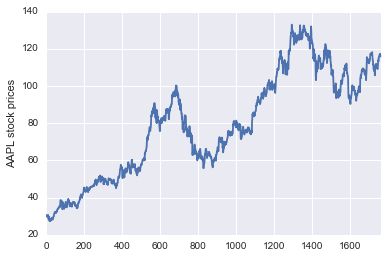

In [218]:
%matplotlib inline
## visualize Apple's stock prices
plot_close_prices_by_symbol('AAPL', prices_dataset)

In [219]:
all_company_prices = prices_dataset['close']
minimum_price = np.min(all_company_prices)
maximum_price = np.max(all_company_prices)
mean_price = np.mean(all_company_prices)
median_price = np.median(all_company_prices)
std_price = np.std(all_company_prices)

# Show the calculated statistics
print "Statistics for S&P 500 datasets:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for S&P 500 datasets:

Minimum price: $1.59
Maximum price: $1,578.13
Mean price: $65.01
Median price $48.48
Standard deviation of prices: $75.20


[422  64   8   1   1   4   0   0   0   1]


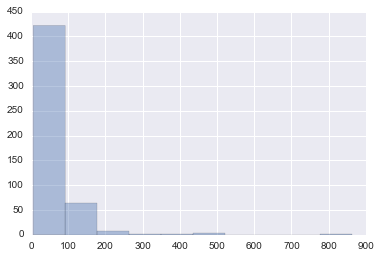

In [220]:
## check if outlier company exists
mean_company_prices = prices_dataset.groupby('symbol')['close'].mean()
sns.distplot(mean_company_prices.values, kde=False, rug=False, bins=10)

hist, bin_edges = np.histogram(mean_company_prices.values, bins=10)
print hist

[  3   4   4   0   6  14   0   0   1 469]
1762


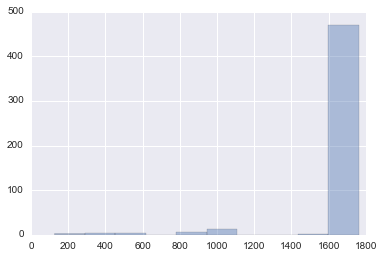

In [221]:
## check if young company exists
company_history = prices_dataset.groupby('symbol')['close'].count()
sns.distplot(company_history.values, kde=False, rug=False, bins=10)

hist, bin_edges = np.histogram(company_history.values, bins=10)
print hist
max_history = company_history.max()
print max_history

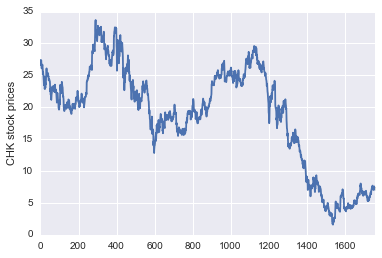

In [222]:
%matplotlib inline
## Visualize prices of company that has min price.
min_company_symbol = prices_dataset[prices_dataset['close']==minimum_price]['symbol'].values[0]
plot_close_prices_by_symbol(min_company_symbol, prices_dataset)

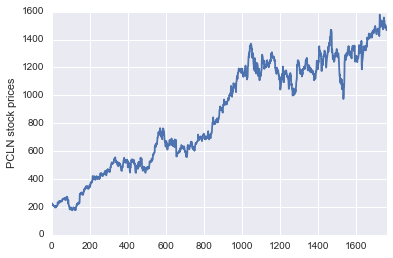

In [223]:
%matplotlib inline
## Visualize prices of company that has max price.
max_company_symbol = prices_dataset[prices_dataset['close']==maximum_price]['symbol'].values[0]
plot_close_prices_by_symbol(max_company_symbol, prices_dataset)

## Preprocessing
Before building models, I have to do data preprocessing.  
Based on the results of Data Exploration, Based on the results of Data Exploration, I determined to exclude outliers and young companies.

In [224]:
## exclude outliers and young company.
excluded_outlier_df = pd.DataFrame({'symbol':mean_company_prices[mean_company_prices < 600].index})
excluded_young_df = pd.DataFrame({'symbol':company_history[company_history == max_history].index})

excluded_outlier_dataset = pd.merge(prices_dataset, excluded_outlier_df, on='symbol')
excluded_dataset = pd.merge(excluded_outlier_dataset, excluded_young_df, on='symbol')

all_company_prices = excluded_dataset['close']
minimum_price = np.min(all_company_prices)
maximum_price = np.max(all_company_prices)
mean_price = np.mean(all_company_prices)
median_price = np.median(all_company_prices)
std_price = np.std(all_company_prices)

# Show the calculated statistics
print "Statistics for S&P 500 datasets:\n"
print "Number of company: {:,d}".format(excluded_dataset.groupby('symbol')['close'].apply(list).count())
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for S&P 500 datasets:

Number of company: 466
Minimum price: $1.59
Maximum price: $844.36
Mean price: $63.54
Median price $48.49
Standard deviation of prices: $63.98


In [241]:
sample_company_num = 20
seed = 42
excluded_indexes = excluded_dataset.groupby('symbol').count().index.values
random.seed(seed)
random.shuffle(excluded_indexes)
sample_indexes = excluded_indexes[:sample_company_num]
sample_company_df = pd.DataFrame({'symbol':sample_indexes})
sampled_dataset = pd.merge(excluded_dataset, sampled_company_df, on='symbol')

## Build benchmark models

In [243]:
# create training and testing dataset.
train_ratio = 0.7
train_size = int(max_history * train_ratio)
test_size = max_history - train_size

company_prices = sampled_dataset.groupby('symbol')['close'].apply(list)
company_prices_train = company_prices.apply(lambda x : x[0:train_size])
company_prices_test = company_prices.apply(lambda x : x[train_size:max_history])

In [394]:
# use 25 timesteps to predict next 1 time step.
use_time_steps = 25
predict_time_steps = 1

In [395]:
## function to create training dataset.
def create_dataset(dataset, time_steps= 1):  
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps - 1):
        a = dataset[i : (i + time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [396]:
def create_train_test_dataset(train_prices, test_prices):    
    train_x_base = train_prices.apply(lambda x : create_dataset(x, use_time_steps)[0])
    train_y_base = train_prices.apply(lambda x : create_dataset(x, use_time_steps)[1])
    test_x_base = test_prices.apply(lambda x : create_dataset(x, use_time_steps)[0])
    test_y_base = test_prices.apply(lambda x : create_dataset(x, use_time_steps)[1])

    train_x, train_y, test_x, test_y = [], [], [], []
    for _, value in np.ndenumerate(train_x_base):
        train_x.extend(value)
    for _, value in np.ndenumerate(train_y_base):
        train_y.extend(value)
    for _, value in np.ndenumerate(test_x_base):
        test_x.extend(value)
    for _, value in np.ndenumerate(test_y_base):
        test_y.extend(value)
    
    train_x, train_y, test_x, test_y = np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y)
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = create_train_test_dataset(company_prices_train, company_prices_test)

In [397]:
# helper function to build benchmark models.
def calc_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

def get_prediction_result(row, pred_func, time_steps):
    x, y = create_dataset(row, time_steps)
    predicted = pred_func(x)
    return np.array([y, predicted])

In [398]:
# Benchmark1 : the model outputs the historical mean value.
predict_benchmark1 = lambda x : np.mean(x, axis = 1)
benchmark1_res = company_prices_test.apply(lambda x : get_prediction_result(x, predict_benchmark1, use_time_steps))
benchmark1_rmse = benchmark1_res.apply(lambda x : calc_rmse(x[0, :], x[1, :]))
benchmark1_total_rmse = np.mean(benchmark1_rmse)
print "RMSE of Benchmark 1: {:,.4f}".format(benchmark1_total_rmse)

RMSE of Benchmark 1: 4.6180


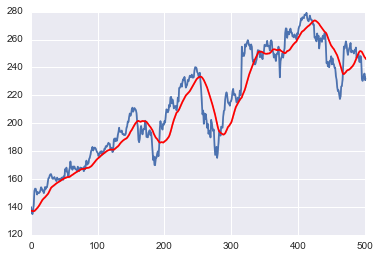

In [399]:
# visualize output of benchmark model 1.
sns.tsplot(data=benchmark1_res['AYI'][0, :])
sns.tsplot(data=benchmark1_res['AYI'][1, :], color="r")

In [400]:
# Benchmark2 : the model outputs the very last observation out.
predict_benchmark2 = lambda x : x[:, -1]
benchmark2_res = company_prices_test.apply(lambda x : get_prediction_result(x, predict_benchmark2, use_time_steps))
benchmark2_rmse = benchmark2_res.apply(lambda x : calc_rmse(x[0, :], x[1, :]))
benchmark2_total_rmse = np.mean(benchmark2_rmse)
print "RMSE of Benchmark 2: {:,.4f}".format(np.mean(benchmark2_total_rmse))

RMSE of Benchmark 2: 1.6636


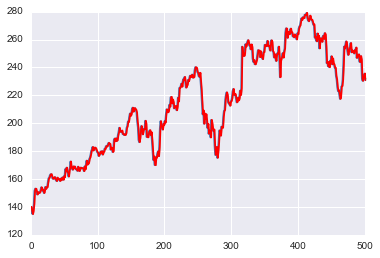

In [401]:
# visualize output of benchmark model 2.
sns.tsplot(data=benchmark2_res['AYI'][0, :])
sns.tsplot(data=benchmark2_res['AYI'][1, :], color="r")

In [412]:
# Build Simple LSTM Model
def build_simple_lstm_model(layers):
    model = Sequential()

    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(layers[2],kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss="mse", optimizer="rmsprop")
    return model

In [408]:
# Log arthimetic
log_train_x = np.log(train_x)
log_train_y = np.log(train_y)
log_test_x = np.log(test_x)
log_test_y = np.log(test_y)

In [409]:
# Normalization
reshape_train_x = log_train_x.reshape(log_train_x.shape[0], log_train_x.shape[1])
reshape_test_x = log_test_x.reshape(log_test_x.shape[0], log_test_x.shape[1])

In [410]:
train_x_normalize_values = np.apply_along_axis(lambda x : np.full(x.shape[0], x[0]), 1, reshape_train_x)
train_y_normalize_values = np.apply_along_axis(lambda x : x[0], 1, reshape_train_x)
test_x_normalize_values = np.apply_along_axis(lambda x : np.full(x.shape[0], x[0]), 1, reshape_test_x)
test_y_normalize_values = np.apply_along_axis(lambda x : x[0], 1, reshape_test_x)

In [411]:
train_x_preprocessed = reshape_train_x / train_x_normalize_values - 1
train_y_preprocessed = log_train_y / train_y_normalize_values - 1
test_x_preprocessed = reshape_test_x / test_x_normalize_values - 1
test_y_preprocessed = log_test_y / test_y_normalize_values - 1

train_x_preprocessed = np.reshape(train_x_preprocessed, (train_x_preprocessed.shape[0], train_x_preprocessed.shape[1], 1))
test_x_preprocessed = np.reshape(test_x_preprocessed, (test_x_preprocessed.shape[0], test_x_preprocessed.shape[1], 1))

In [413]:
epochs = 15
model = build_simple_lstm_model([1, 25, 1])
model.fit(train_x_preprocessed, train_y_preprocessed, batch_size=256, epochs=epochs, validation_split=0.05, shuffle=True, verbose=1)

Train on 22933 samples, validate on 1207 samples
Epoch 1/15
22933/22933 [==============================] - 103s - loss: 3.9038e-04 - val_loss: 2.4854e-04
Epoch 2/15
13056/22933 [================>.............] - ETA: 41s - loss: 1.4785e-04

KeyboardInterrupt: 

In [352]:
trainScore = model.evaluate(train_x_preprocessed, train_y_preprocessed, verbose=1)
testScore = model.evaluate(test_x_preprocessed, test_y_preprocessed, verbose=1)
print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

9536/9560 [============================>.] - ETA: 0sTrain Score: 0.00004 MSE (0.01 RMSE)
Test Score: 0.00003 MSE (0.01 RMSE)


In [351]:
predict = model.predict(test_x_preprocessed, verbose=1)

9536/9560 [============================>.] - ETA: 0s

In [382]:
# re-normalized
predict_renormalized = (predict.reshape(predict.shape[0]) + 1) * test_y_normalize_values
predict_renormalized = np.exp(predict_renormalized)

In [387]:
actuals = []
predicts = []
rmses = []
for i in range(sample_company_num):
    start_index = i * data_per_company
    end_index = (i + 1) * (data_per_company)
    lstm_rmse = calc_rmse(test_y[start_index:end_index], predict_renormalized[start_index:end_index].reshape(data_per_company))
    actuals.append(test_y[start_index:end_index])
    predicts.append(predict_renormalized[start_index:end_index].reshape(data_per_company))
    rmses.append(lstm_rmse)
    print('Test Score: index%d %.2f RMSE' % (i, lstm_rmse))
print('Total Test Score: %.2f RMSE' % np.mean(rmses))

Test Score: index0 5.42 RMSE
Test Score: index1 4.11 RMSE
Test Score: index2 1.07 RMSE
Test Score: index3 1.39 RMSE
Test Score: index4 1.59 RMSE
Test Score: index5 3.54 RMSE
Test Score: index6 3.21 RMSE
Test Score: index7 2.52 RMSE
Test Score: index8 1.13 RMSE
Test Score: index9 4.39 RMSE
Test Score: index10 3.31 RMSE
Test Score: index11 0.72 RMSE
Test Score: index12 0.99 RMSE
Test Score: index13 2.39 RMSE
Test Score: index14 0.67 RMSE
Test Score: index15 2.51 RMSE
Test Score: index16 3.22 RMSE
Test Score: index17 1.92 RMSE
Test Score: index18 2.02 RMSE
Test Score: index19 2.30 RMSE
Total Test Score: 2.42 RMSE


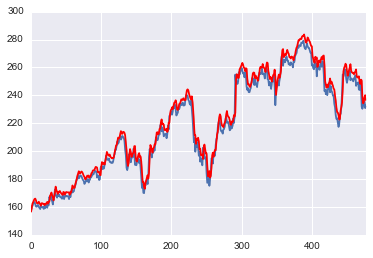

In [386]:
sns.tsplot(data=actuals[0])
sns.tsplot(data=predicts[0], color="r")

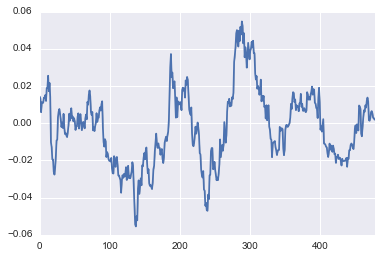

In [393]:
sns.tsplot(data=test_y_preprocessed[11*data_per_company:12*data_per_company])